### Data loading is straight from Ramon's Exploration1 notebook

In [192]:
import numpy as np
import pandas as pd
import os
import tempfile

import matplotlib.pyplot as plt

%matplotlib inline

In [193]:
from os import listdir
from os.path import isfile, join
path_train = 'ignored_assets/public_data/training_data/order_data'
trainfiles = [f for f in listdir(path_train) if isfile(join(path_train, f)) and f != '.DS_Store']

path_test1 = 'ignored_assets/public_data/test_set_1/order_data'
testfiles1 = [f for f in listdir(path_test1) if isfile(join(path_test1, f)) and f != '.DS_Store']

path_test2 = 'ignored_assets/public_data/test_set_2/order_data'
testfiles2 = [f for f in listdir(path_test2) if isfile(join(path_test2, f)) and f != '.DS_Store']


In [194]:
orderdf_train = []
for f in trainfiles:
    orderdf_train.append(pd.read_csv(join(path_train, f), delimiter='\t', header = None))
    
orderdf_test = []
for f in testfiles1:
    orderdf_test.append(pd.read_csv(join(path_test1, f), delimiter='\t', header = None))
    
for f in testfiles2:
    orderdf_test.append(pd.read_csv(join(path_test2, f), delimiter='\t', header = None))


In [195]:
def group_and_label_data(orderdf):
    print "Concatenating and indexing"
    orderdf = pd.concat(orderdf)
    orderdf.index = range(len(orderdf))
    orderdf[6] = pd.to_datetime(orderdf[6])
    orderdf.columns = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'price', 'timestamp']
    orderdf['quarter_hour'] = orderdf['timestamp'].dt.round('15min')
    print "Grouping"
    orderdf_group=orderdf[['order_id', 'start_district_hash', 'quarter_hour']].groupby(['start_district_hash','quarter_hour']).count()
    orderdf_group.columns = ['Orders']
    orderdf_group=orderdf_group.reset_index()
    #orderdf_group=orderdf_group[orderdf_group['Orders']<200]
    print "Labeling"
    orderdf_group["quarter_hour_mins"] = orderdf_group['quarter_hour'].dt.minute+60*orderdf_group['quarter_hour'].dt.hour
    orderdf_group['hour'] = orderdf_group['quarter_hour'].dt.hour
    orderdf_group['weekday'] = orderdf_group['quarter_hour'].dt.weekday
    orderdf_group['weekend'] = orderdf_group['weekday']>4
    
    #Rescaling
    #orderdf_group["Orders"]=np.log(orderdf_group["Orders"])
    orderdf_group["Orders"]=orderdf_group["Orders"]>20
    
    return orderdf_group

In [196]:
orderdf_group_train=group_and_label_data(orderdf_train)
orderdf_group_test =group_and_label_data(orderdf_test)

Concatenating and indexing
Grouping
Labeling
Concatenating and indexing
Grouping
Labeling


In [197]:
orderdf_group_train.head()

,start_district_hash,quarter_hour,Orders,quarter_hour_mins,hour,weekday,weekend
0,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 00:45:00,False,45,0,4,False
1,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 01:00:00,False,60,1,4,False
2,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 01:15:00,False,75,1,4,False
3,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 02:15:00,False,135,2,4,False
4,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01 02:30:00,False,150,2,4,False


### Let's create a stupid linear classifier with TensorFlow

In [198]:
CATEGORICAL_COLUMNS = ["start_district_hash", "quarter_hour_mins","hour", "weekday", "weekend"]
CONTINUOUS_COLUMNS = []
LABEL_COLUMN = ["Orders"]

In [199]:
import tensorflow as tf

def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(continuous_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(orderdf_group_train)

def eval_input_fn():
  return input_fn(orderdf_group_test)


In [201]:
#start_district_hash = tf.contrib.layers.sparse_column_with_keys(
#  column_name="start_district_hash", keys=["Female", "Male"])
start_district_hash = tf.contrib.layers.sparse_column_with_hash_bucket("start_district_hash", hash_bucket_size=66)
quarter_hour_mins = tf.contrib.layers.bucketized_column("quarter_hour_mins",boundaries=range(0,144))
hour = tf.contrib.layers.bucketized_column("hour",boundaries=range(0,24))
weekday = tf.contrib.layers.bucketized_column("weekday",boundaries=range(0,7))
#weekend = tf.contrib.layers.bucketized_column("weekend", hash_bucket_size2))
weekend = tf.contrib.layers.bucketized_column("weekend",boundaries=range(0,2))

#TODO use sparse_column_with_integerized_feature 

TypeError: source_column must be an instance of _RealValuedColumn. source_column: quarter_hour_mins

In [190]:
model_dir = tempfile.mkdtemp()
#m = tf.contrib.learn.LinearRegressor(feature_columns=[
m = tf.contrib.learn.LinearClassifier(feature_columns=[
  start_district_hash, quarter_hour_mins, hour, weekday],
    optimizer=tf.train.FtrlOptimizer(
    learning_rate=0.1,
    l1_regularization_strength=1.0,
    l2_regularization_strength=1.0),
  model_dir=model_dir)

m2 = tf.contrib.learn.DNNRegressor(
    feature_columns=[start_district_hash, quarter_hour_mins, hour, weekday],
    hidden_units=[512, 256],
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001
    ))


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1b7b9d450>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1b7b9d450>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1b7b9d650>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1b7b9d650>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [191]:
m.fit(input_fn=train_input_fn, steps=5000)

ValueError: Error creating input layer for column: hour.
SparseColumn is not supported in DNN. Please use embedding_column or one_hot_column. column: _SparseColumn(column_name='hour', is_integerized=True, bucket_size=24, lookup_config=None, combiner='sum', dtype=tf.int64), No deep embedding lookup arguments for column _SparseColumn(column_name='hour', is_integerized=True, bucket_size=24, lookup_config=None, combiner='sum', dtype=tf.int64).

In [ ]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))

In [152]:
int(eval_input_fn()[1].shape[0])

15715

In [160]:
preds = list(m.predict(input_fn=eval_input_fn))




Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.


Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmpbXV8_m/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /var/folders/78/dgqg3y1961n3hr5x51lmkmbc0000gp/T/tmpbXV8_m/model.ckpt-5000


NameError: name 'xor' is not defined

In [183]:
preds=pd.Series(preds)

err = preds != orderdf_group_test['Orders']
print "Error:", float(sum(err))/float(len(err))
fpos = preds*(1-orderdf_group_test['Orders'])
print "False positives:", float(sum(fpos))/float(len(err))
fneg = (1-preds)*(orderdf_group_test['Orders'])
print "False negatives:", float(sum(fneg))/float(len(err))

Error: 0.180782691696
False positives: 0.116894686605
False negatives: 0.0638880050907


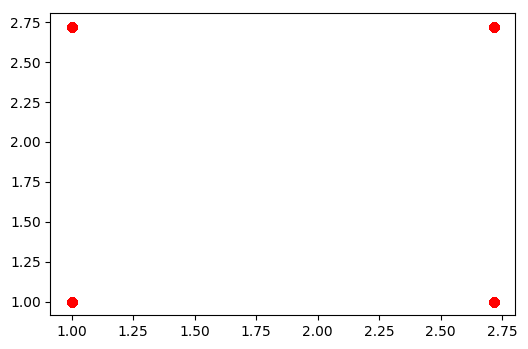

In [159]:
plt.plot(np.exp(orderdf_group_test['Orders']),np.exp(preds),'ro')
plt.axis([0, 1000, 0, 1000])

True

(array([ 8714.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7001.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

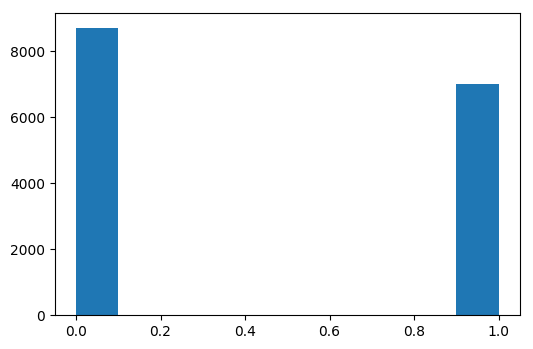

In [156]:
plt.hist(orderdf_group_test['Orders'][orderdf_group_test['Orders']<200])

In [142]:
float(len(orderdf_group_test['Orders'][orderdf_group_test['Orders']<1]))/float(len(orderdf_group_test['Orders']))

0.5984727966910595